In [1]:
import mogptk
import torch
import numpy as np
import pandas as pd

torch.manual_seed(1);

In [2]:
from torch.utils.data import TensorDataset, DataLoader

In [5]:
column_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
                'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

dataset = mogptk.DataSet()
for names in column_names:
    dataset.append(mogptk.LoadCSV('examples/data/currency_exchange/final_dataset.csv',
                                    x_col='Date', y_col=names))

dataset.filter('2017-01-03', '2018-01-01')

()
()
()
()
()
()
()
()
()
()
()


In [6]:
# Preprocess by randomly removing points and detrending
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.transform(mogptk.TransformNormalize())
    channel.remove_randomly(pct=0.3)
    
    if i not in [0, 2, 5]:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

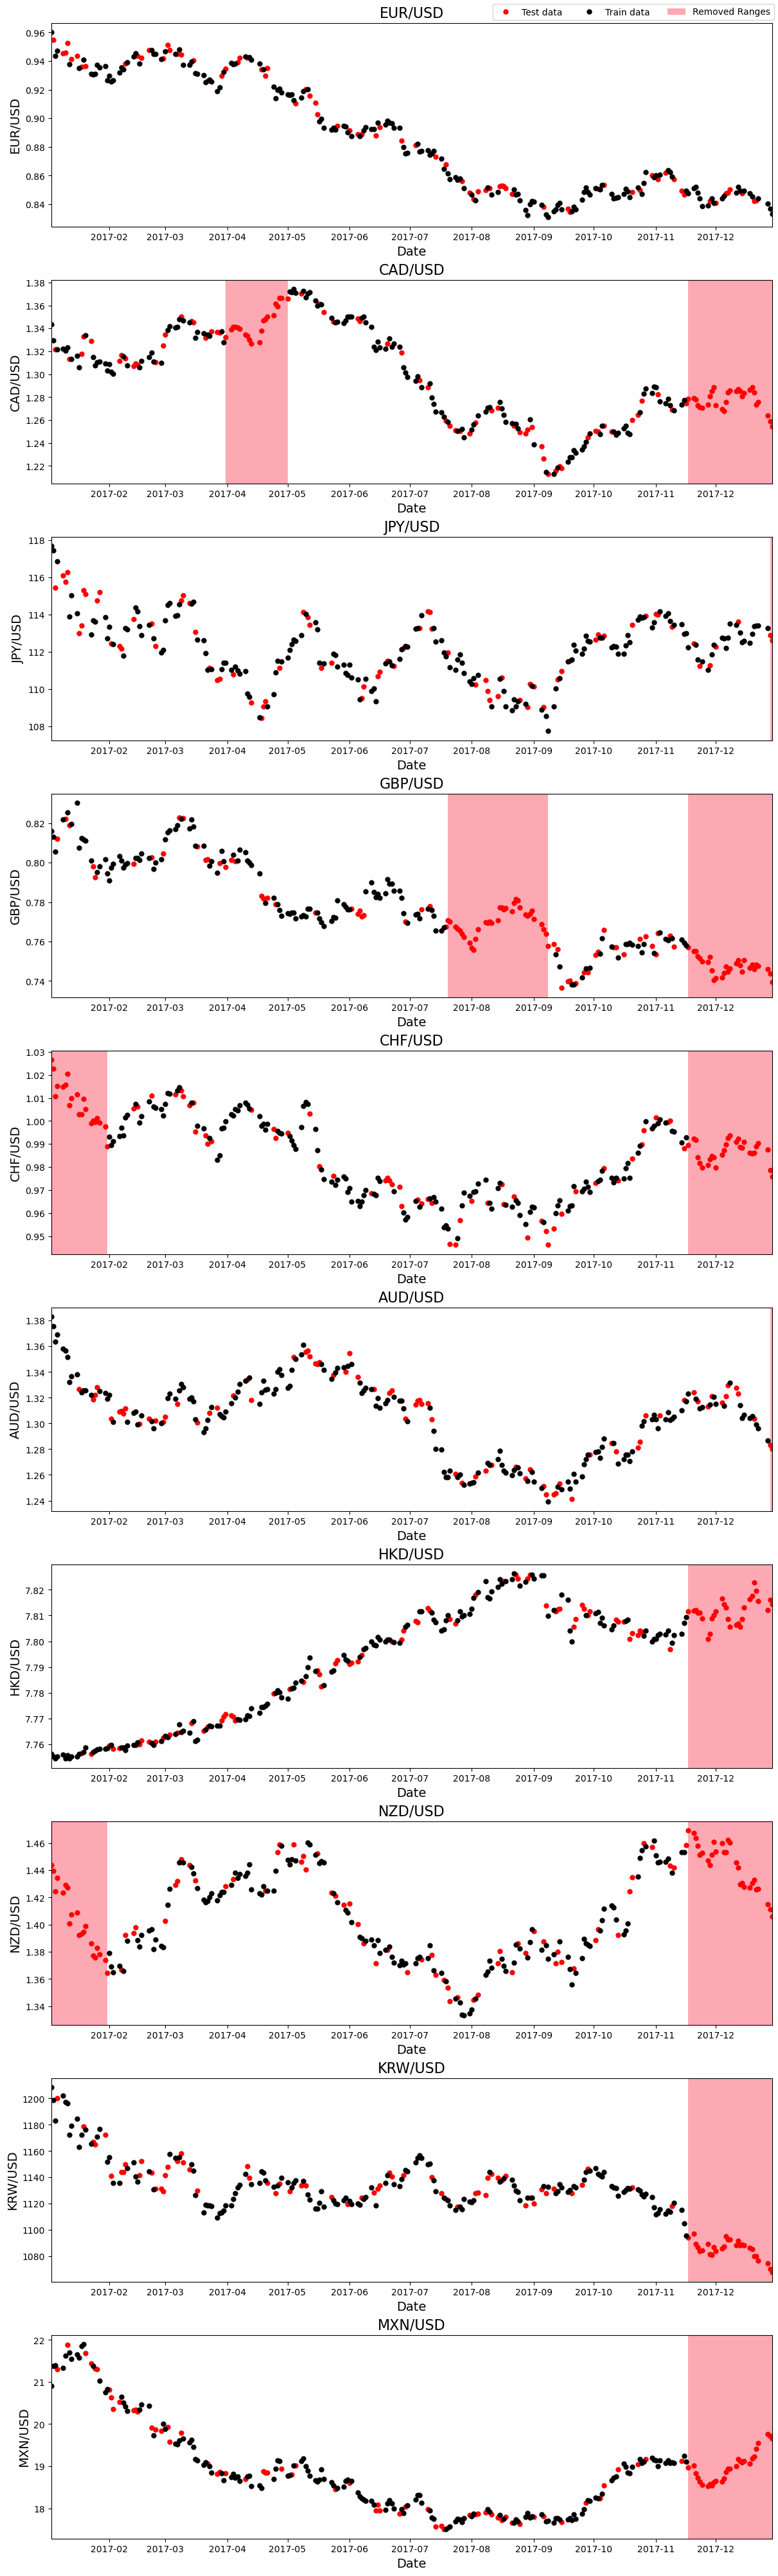

In [7]:
dataset.plot();

In [8]:
n_trials = 3
Q = 3
init_method = 'LS'
method = 'Adam'
lr = 0.1
iters = 1000

In [10]:
ds = dataset.copy()

In [11]:
x, y = dataset.get_train_data()

In [56]:
# now each of the 10 time series are of unequal length. let us pad all of them to maxlen
# Assuming you want to pad the time series to a common length
common_length = max(len(ts) for ts in x)
# Pad time series
px = [np.pad(ts, pad_width=((0, common_length - len(ts)), (0, 0))) for ts in x]

In [57]:
for ts1, ts2 in zip(x, px):
    print(ts1.shape, ts2.shape)

(175, 1) (175, 1)
(138, 1) (175, 1)
(173, 1) (175, 1)
(133, 1) (175, 1)
(144, 1) (175, 1)
(173, 1) (175, 1)
(153, 1) (175, 1)
(140, 1) (175, 1)
(158, 1) (175, 1)
(158, 1) (175, 1)


In [64]:
common_length = max(len(ts) for ts in y)
# Pad time series
py = [np.pad(ts, pad_width=((0, common_length - len(ts)))) for ts in y]

In [65]:
for ts1, ts2 in zip(y, py):
    print(ts1.shape, ts2.shape)

(175,) (175,)
(138,) (175,)
(173,) (175,)
(133,) (175,)
(144,) (175,)
(173,) (175,)
(153,) (175,)
(140,) (175,)
(158,) (175,)
(158,) (175,)


In [66]:
py = np.array(py).transpose(1, 0)

In [68]:
px = np.concatenate(px, -1)

In [72]:
train_ds = TensorDataset(torch.from_numpy(px), torch.from_numpy(py))
train_loader = DataLoader(train_ds, batch_size=8)

In [9]:
def get_torch_dataloader(dataset, batch_size):
    x, y = dataset.get_train_data()
    # Assuming you want to pad the time series to a common length
    common_length = max(len(ts) for ts in x)
    # Pad time series
    px = [np.pad(ts, pad_width=((0, common_length - len(ts)), (0, 0))) for ts in x]
    common_length = max(len(ts) for ts in y)
    # Pad time series
    py = [np.pad(ts, pad_width=((0, common_length - len(ts)))) for ts in y]
    px = np.concatenate(px, -1)
    py = np.array(py).transpose(1, 0)
    train_ds = TensorDataset(torch.from_numpy(px), torch.from_numpy(py))
    train_loader = DataLoader(train_ds, batch_size=8)
    return train_loader

In [10]:
mosm_models = []
mosm_mae = np.zeros((n_trials,10))
mosm_rmse = np.zeros((n_trials,10))
mosm_mape = np.zeros((n_trials,10))

# experiment trials
for n in range(n_trials):
    mosm_dataset = dataset.copy()
    for i, channel in enumerate(mosm_dataset):
        channel.remove_randomly(pct=0.3)
    
    train_loader = get_torch_dataloader(mosm_dataset, 8)
    print('\nTrial', n+1, 'of', n_trials)
    num_inducing = 2**3
    mosm = mogptk.MOSM(dataset=mosm_dataset, train_loader=train_loader, 
                       inference=mogptk.model.Hensman(inducing_points=num_inducing),
                       Q=Q)
    mosm.init_parameters(method=init_method)
    mosm.train(method=method, lr=lr, iters=iters, verbose=True, jit=False)
    # mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3
Starting optimization using Adam
‣ Model: SparseHensman
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 10
‣ Parameters: 3551
‣ Training points: 1067
‣ Iterations: 1000


AttributeError: 'NoneType' object has no attribute 'shape'